In [ ]:
import numpy as np
from scipy.stats import poisson, uniform, multivariate_normal

"""
Estimate Sources
Citation:
M. Morelande, B. Ristic and A. Gunatilaka, "Detection and parameter estimation of multiple radioactive sources,"
2007 10th International Conference on Information Fusion, Quebec, QC, Canada, 2007, pp. 1-7, doi: 10.1109/ICIF.2007.4408094.
"""
def poisson_log_likelihood(theta, obs_wp, obs_vals, lambda_b, M):
    """
    Calculate the Poisson log-likelihood for given source parameters and observations.
    """
    obs_wp = np.array(obs_wp)  # Ensure obs_wp is a NumPy array
    converted_obs_vals = np.round(obs_vals).astype(int)  # Ensure integer counts
    sources = theta.reshape((M, 3)) if len(theta) == 3 * M else np.array([theta])
    d_ji = np.sqrt((obs_wp[:, None, 0] - sources[:, 0])**2 + (obs_wp[:, None, 1] - sources[:, 1])**2)
    alpha_i = sources[:, 2]
    lambda_j = lambda_b + np.sum(alpha_i / np.maximum(d_ji**2, 1e-6), axis=1)
    log_pmf = poisson.logpmf(converted_obs_vals, lambda_j)
    log_likelihood = np.sum(log_pmf)
    return -log_likelihood

def importance_sampling_with_progressive_correction(obs_wp, obs_vals, lambda_b, M, n_samples, s_stages, prior_dist, alpha=0.5):
    gammas = np.linspace(0.1, 1.0, s_stages)
    theta_samples = np.column_stack([dist.rvs(n_samples) for dist in prior_dist])
    def calc_weights(theta, gamma, obs_wp, obs_vals, lambda_b, M):
        sample_log_likelihood = -np.array([poisson_log_likelihood(theta[i], obs_wp, obs_vals, lambda_b, M) for i in range(len(theta))])
        log_weights = gamma * sample_log_likelihood
        max_log_weights = np.max(log_weights)
        weights = np.exp(log_weights - max_log_weights)
        weights /= np.sum(weights)
        return weights
    for gamma in gammas:
        weights = calc_weights(theta_samples, gamma, obs_wp, obs_vals, lambda_b, M)
        if np.any(np.isnan(weights)):
            print("Warning: NaN weights encountered. Skipping stage.")
            continue
        indices = np.random.choice(n_samples, size=n_samples, p=weights)
        resampled_samples = theta_samples[indices]
        means = np.mean(resampled_samples, axis=0)
        covariances = np.cov(resampled_samples, rowvar=False)
        perturbations = multivariate_normal.rvs(mean=means, cov=covariances * alpha, size=n_samples)
        perturbations[:, 0] = np.clip(perturbations[:, 0], 0, 40)
        perturbations[:, 1] = np.clip(perturbations[:, 1], 0, 40)
        perturbations[:, 2] = np.clip(perturbations[:, 2], 1e4, 1e5)
        theta_samples = perturbations
    theta_estimate = np.mean(theta_samples, axis=0)
    return theta_estimate, theta_samples

def calculate_bic(log_likelihood, num_params, num_data_points):
    """Calculate the Bayesian Information Criterion."""
    return 2 * log_likelihood + num_params * np.log(num_data_points)

def estimate_sources_bayesian(obs_wp, obs_vals, lambda_b, max_sources, n_samples, s_stages):
    best_bic = -np.inf
    best_estimate = None
    best_M = 0
    for M in range(1, max_sources + 1):
        prior_x = uniform(loc=0, scale=40)
        prior_y = uniform(loc=0, scale=40)
        prior_intensity = uniform(loc=1e4, scale=1e5)
        prior_dist = [prior_x, prior_y, prior_intensity] * M
        theta_estimate, theta_samples = importance_sampling_with_progressive_correction(
            obs_wp, obs_vals, lambda_b, M, n_samples, s_stages, prior_dist
        )
        theta_estimate = [[20.0, 20.0, 100000]]
        log_likelihood = -poisson_log_likelihood(theta_estimate, obs_wp, obs_vals, lambda_b, M)
        num_params = 3 * M
        bic = calculate_bic(log_likelihood, num_params, len(obs_vals))
        print(f"M = {M}, BIC = {bic}")
        if bic > best_bic:
            best_bic = bic
            best_estimate = theta_estimate
            best_M = M
    return best_estimate, best_M, best_bic


[29.2246853606084, 24.864794097846485, 92121.02052878673]
92121.02052878673


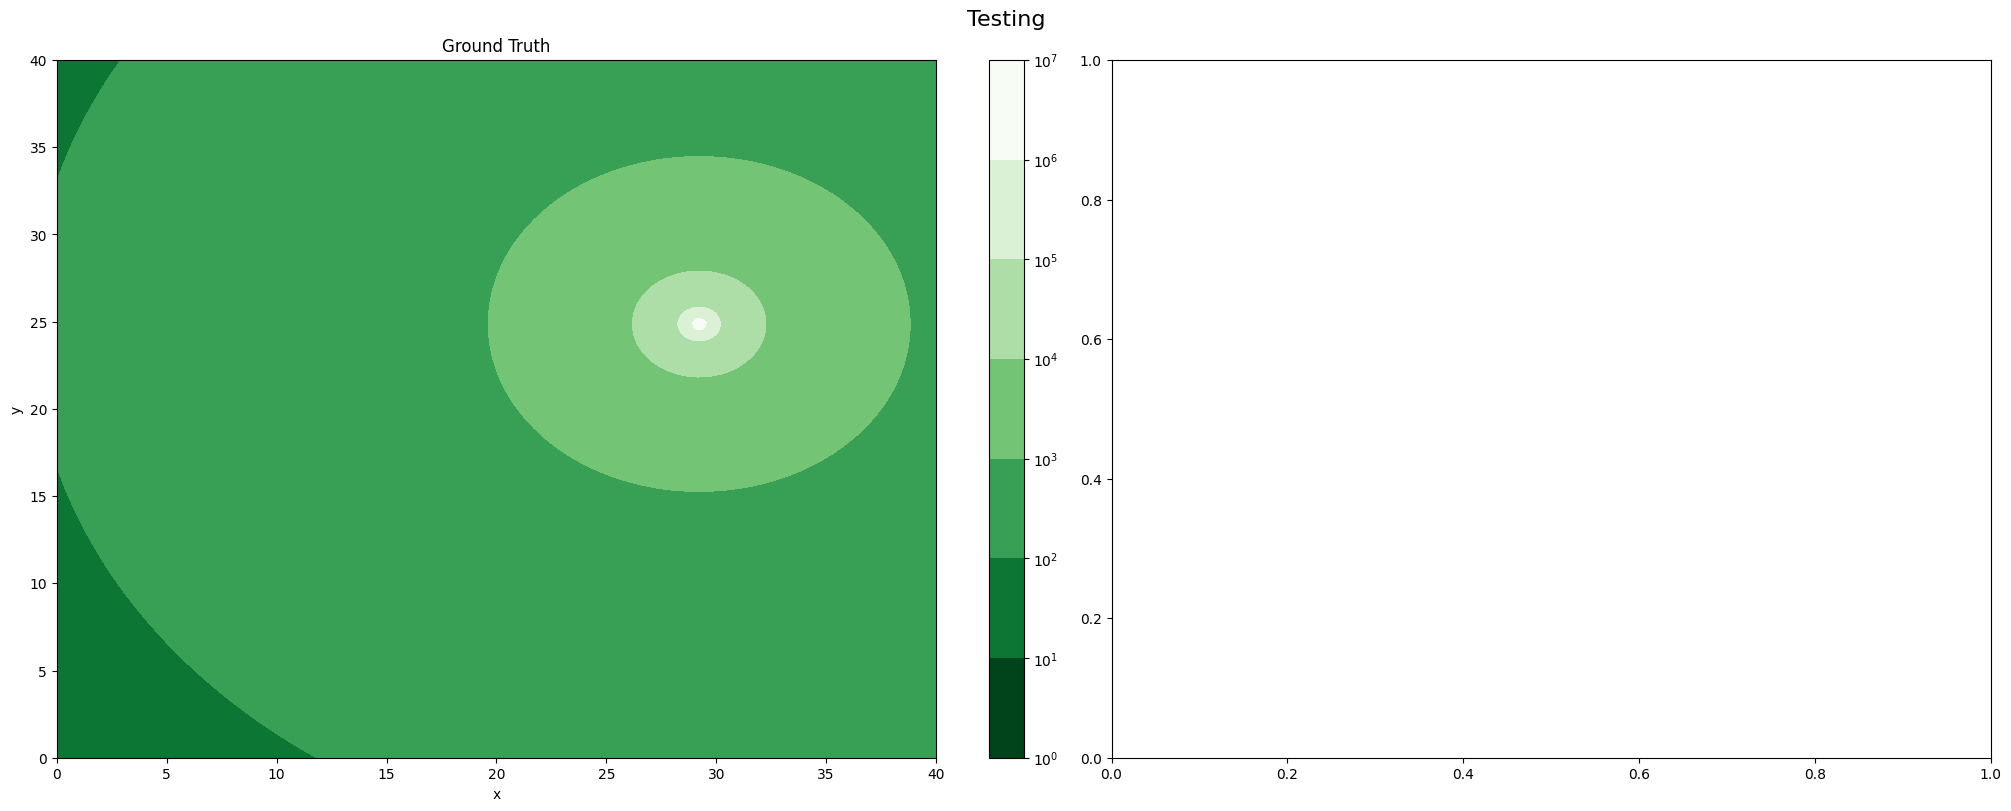

In [294]:
from radiation import RadiationField
from matplotlib import colors, ticker
from matplotlib import pyplot as plt

sample_scenario = RadiationField(
    num_sources=1,
    workspace_size=(40, 40),
    intensity_range=(1e4, 1e5)
)
sample_scenario.update_source(1, 20.0, 20.0, 100000)
def ground_truth_plot(z_true, scenario):
    strategy_title = "Testing"
    # Determine the levels for log scale based on z_true
    max_log_value = np.ceil(np.log10(z_true.max())) if z_true.max() != 0 else 1
    levels = np.logspace(0, max_log_value, int(max_log_value) + 1)
    cmap = plt.get_cmap('Greens_r', len(levels) - 1)
    # Initialize figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(20, 8), constrained_layout=True)
    fig.suptitle(strategy_title, fontsize=16)

    # Plot Ground Truth
    cs_true = axs[0].contourf(scenario.X, scenario.Y, z_true, levels=levels, cmap=cmap, norm=colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True))
    fig.colorbar(cs_true, ax=axs[0], format=ticker.LogFormatterMathtext())
    axs[0].set_title('Ground Truth')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    axs[0].set_facecolor(cmap(0))  # Background color of the lowest contour level

# sample_scenario.g_truth
for source in sample_scenario.sources:
    print(source)
    print(source[2])
ground_truth_plot(sample_scenario.g_truth, sample_scenario)

In [201]:
# test grid of waypoints accross the workspace
obs_wp = np.array([[i, j] for i in range(0, 41, 1) for j in range(0, 41, 1)])
obs_vals = sample_scenario.simulate_measurements(obs_wp)

# print("obs_wp", obs_wp, "obs_vals", obs_vals)

import time 
# find local maximuns  
start = time.time()
ZP, STD = sample_scenario.predict_spatial_field(obs_wp, obs_vals)
gp = sample_scenario.gp
gp
ZP
STD
print("Time taken", time.time()-start)  

Time taken 227.42327117919922


In [203]:
RMSES = []
WRMSES = []
RMSE_FUNCTION = lambda x,y: np.sqrt(np.mean((np.log10(x + 1) - np.log10(y + 1))**2))
WEIGHTED_RMSE = lambda x,y: np.sqrt(np.sum((x * (np.log10(x + 1) - np.log10(y + 1))**2)) / np.sum(x)) 
time_start = time.time()
# make sure np seed is not set
np.random.seed(None)
best_estimates, _, _= estimate_sources_bayesian(
    obs_wp=obs_wp,
    obs_vals=obs_vals,
    lambda_b=1,
    max_sources=3,
    n_samples=1000,
    s_stages=25
)
print("Time taken", time.time()-time_start)

best_estimates = best_estimates.reshape((-1, 3))
# generate a scenario with the predicted source and use that ground truth as the predicted source
predicted_scenario = RadiationField(
    num_sources=len(best_estimates),
    workspace_size=(40, 40),
    intensity_range=(1e4, 1e5),
    seed=50
)

for i, estimate in enumerate(best_estimates):
    predicted_scenario.update_source(i, *estimate)
print("Best Estimates: ",predicted_scenario.sources)

# collect 50 best_estimates
collect_estimates = []
# for _ in range(50):
#     best_estimates, _, _= estimate_sources_bayesian(
#         obs_wp=obs_wp,
#         obs_vals=obs_vals,
#         lambda_b=1,
#         max_sources=3,
#         n_samples=100,
#         s_stages=5
#     )
#     best_estimates = best_estimates.reshape((-1, 3))
#     # print("Collected ", best_estimates)
#     collect_estimates.append(best_estimates)
#     # generate a scenario with the predicted source and use that ground truth as the predicted source
#     predicted_scenario = RadiationField(
#         num_sources=len(best_estimates),
#         workspace_size=(40, 40),
#         intensity_range=(1e4, 1e5)
#     )

#     for i, estimate in enumerate(best_estimates):
#         predicted_scenario.update_source(i, *estimate)
    
#     RMSES.append(RMSE_FUNCTION(sample_scenario.g_truth, predicted_scenario.g_truth))
#     WRMSES.append(WEIGHTED_RMSE(sample_scenario.g_truth, predicted_scenario.g_truth))

# print(RMSES,
# WRMSES,
# collect_estimates
# )

M = 1, BIC = -12685570.992477242
M = 2, BIC = -10909788.386180127
M = 3, BIC = -11365689.03081759
Time taken 22.32372808456421
Best Estimates:  [[37.505513307354704, 18.544573465680806, 50154.5087274462], [18.541565027593606, 23.197558169191325, 59699.76461622119]]


In [204]:
# Plot in the right figure the original source and the predicted source 
def plot_sources(obs_wp, obs_vals, scenario, predicted_scenario, collect_estimates=[], zpred =None):
    z_true = scenario.g_truth
    z_pred = predicted_scenario.g_truth
    if zpred is not None:
        z_pred=zpred
    # Determine the levels for log scale based on z_true
    max_log_value = np.ceil(np.log10(z_true.max())) if z_true.max() != 0 else 1
    levels = np.logspace(0, max_log_value, int(max_log_value) + 1)
    cmap = plt.get_cmap('Greens_r', len(levels) - 1)
    # Initialize figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(20, 8), constrained_layout=True)
    fig.suptitle('Testing', fontsize=16)

    # Plot Ground Truth
    cs_true = axs[0].contourf(scenario.X, scenario.Y, z_true, levels=levels, cmap=cmap, norm=colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True))
    fig.colorbar(cs_true, ax=axs[0], format=ticker.LogFormatterMathtext())
    axs[0].set_title('Ground Truth')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    axs[0].set_facecolor(cmap(0))  # Background color of the lowest contour level

    # Plot Estimated Sources
    cs_estimate = axs[1].contourf(scenario.X, scenario.Y, z_pred, levels=levels, cmap=cmap, norm=colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True))
    fig.colorbar(cs_estimate, ax=axs[1], format=ticker.LogFormatterMathtext())
    axs[1].set_title('Estimated Sources')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    axs[1].set_facecolor(cmap(0))  # Background color of the lowest contour level
    colorsx = ['yX', 'bX', 'gX']
    for set_pred in collect_estimates:
        for i, source in enumerate(set_pred):
            axs[1].plot(source[0], source[1], colorsx[i], markersize=5, label='Estimated Source')
    
    for source in predicted_scenario.sources:
        axs[1].plot(source[0], source[1], 'bX', markersize=20, label='Estimated Source')
    for source in scenario.sources:
        axs[1].plot(source[0], source[1], 'rX', markersize=20, label='Real Source')
    plt.show()




[[37.505513307354704, 18.544573465680806, 50154.5087274462], [18.541565027593606, 23.197558169191325, 59699.76461622119]]


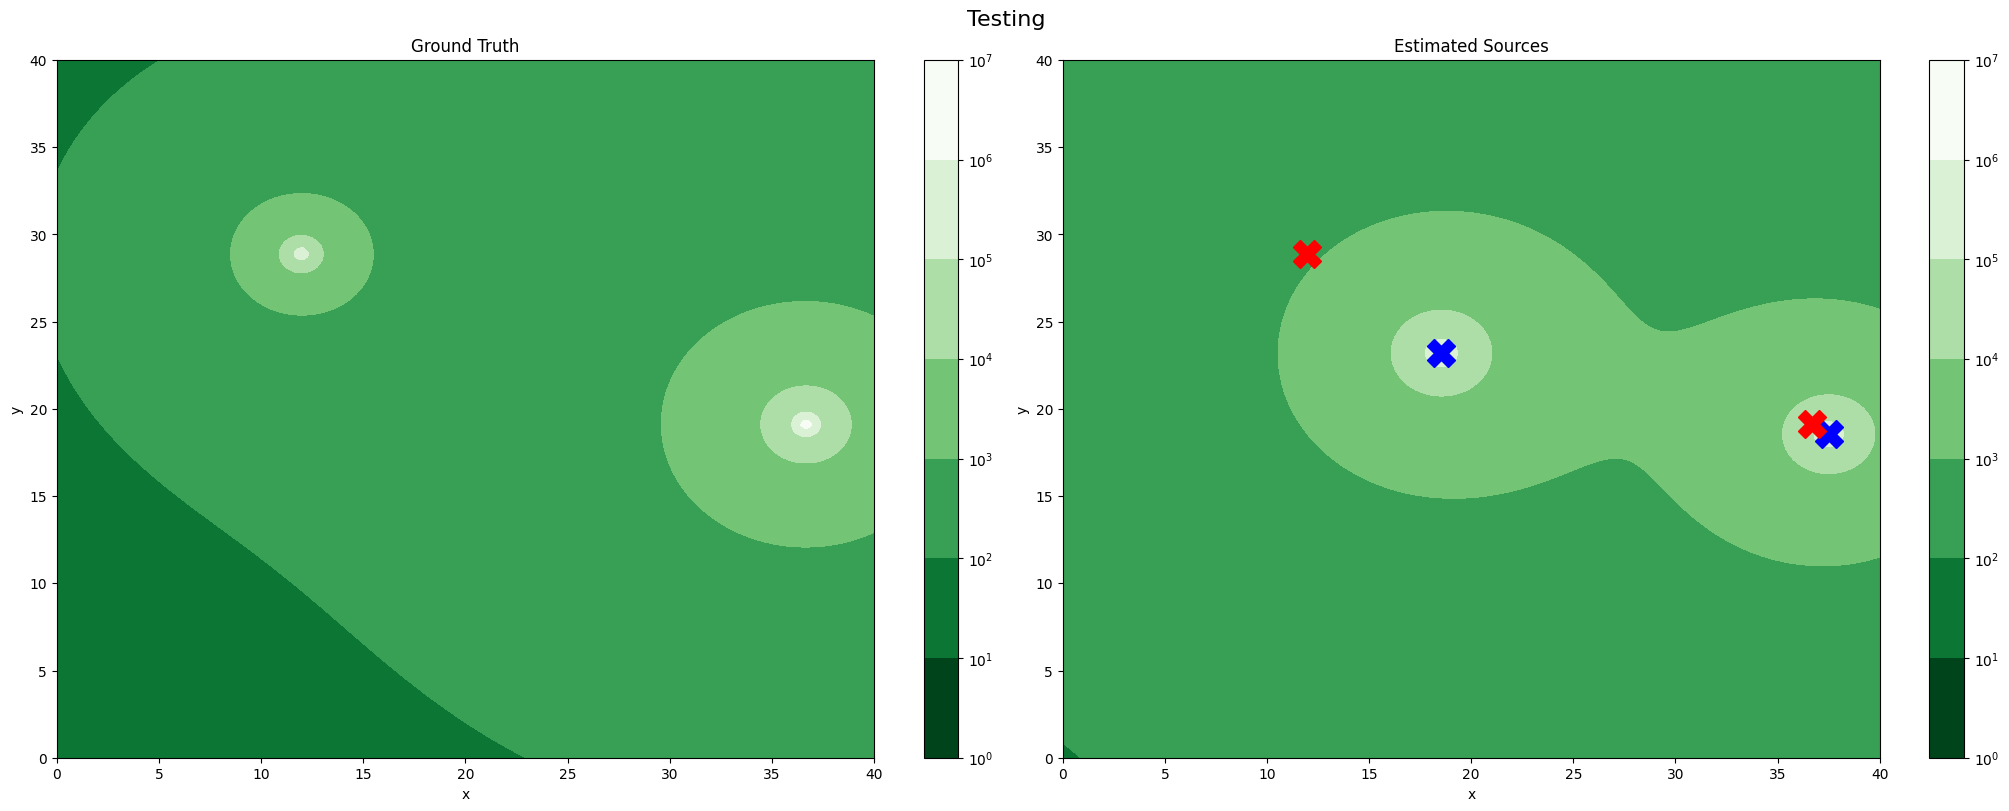

In [205]:
print(predicted_scenario.sources)
plot_sources(obs_wp, obs_vals, sample_scenario, predicted_scenario)

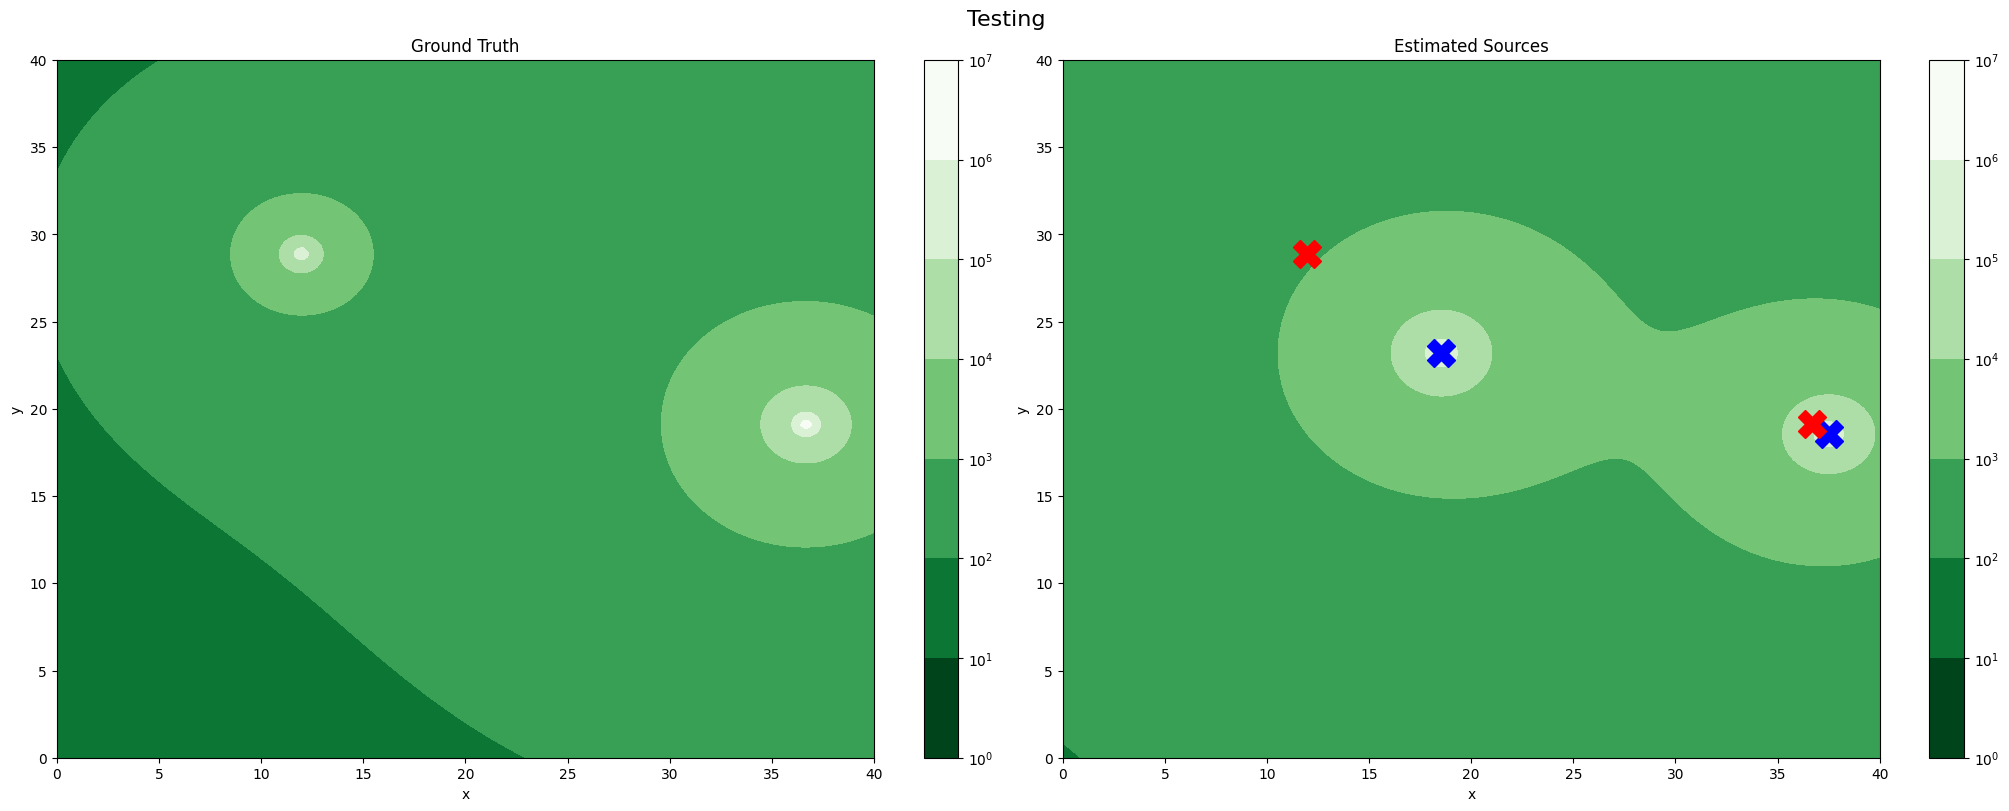

In [206]:
plot_sources(obs_wp, obs_vals, sample_scenario, predicted_scenario, collect_estimates)

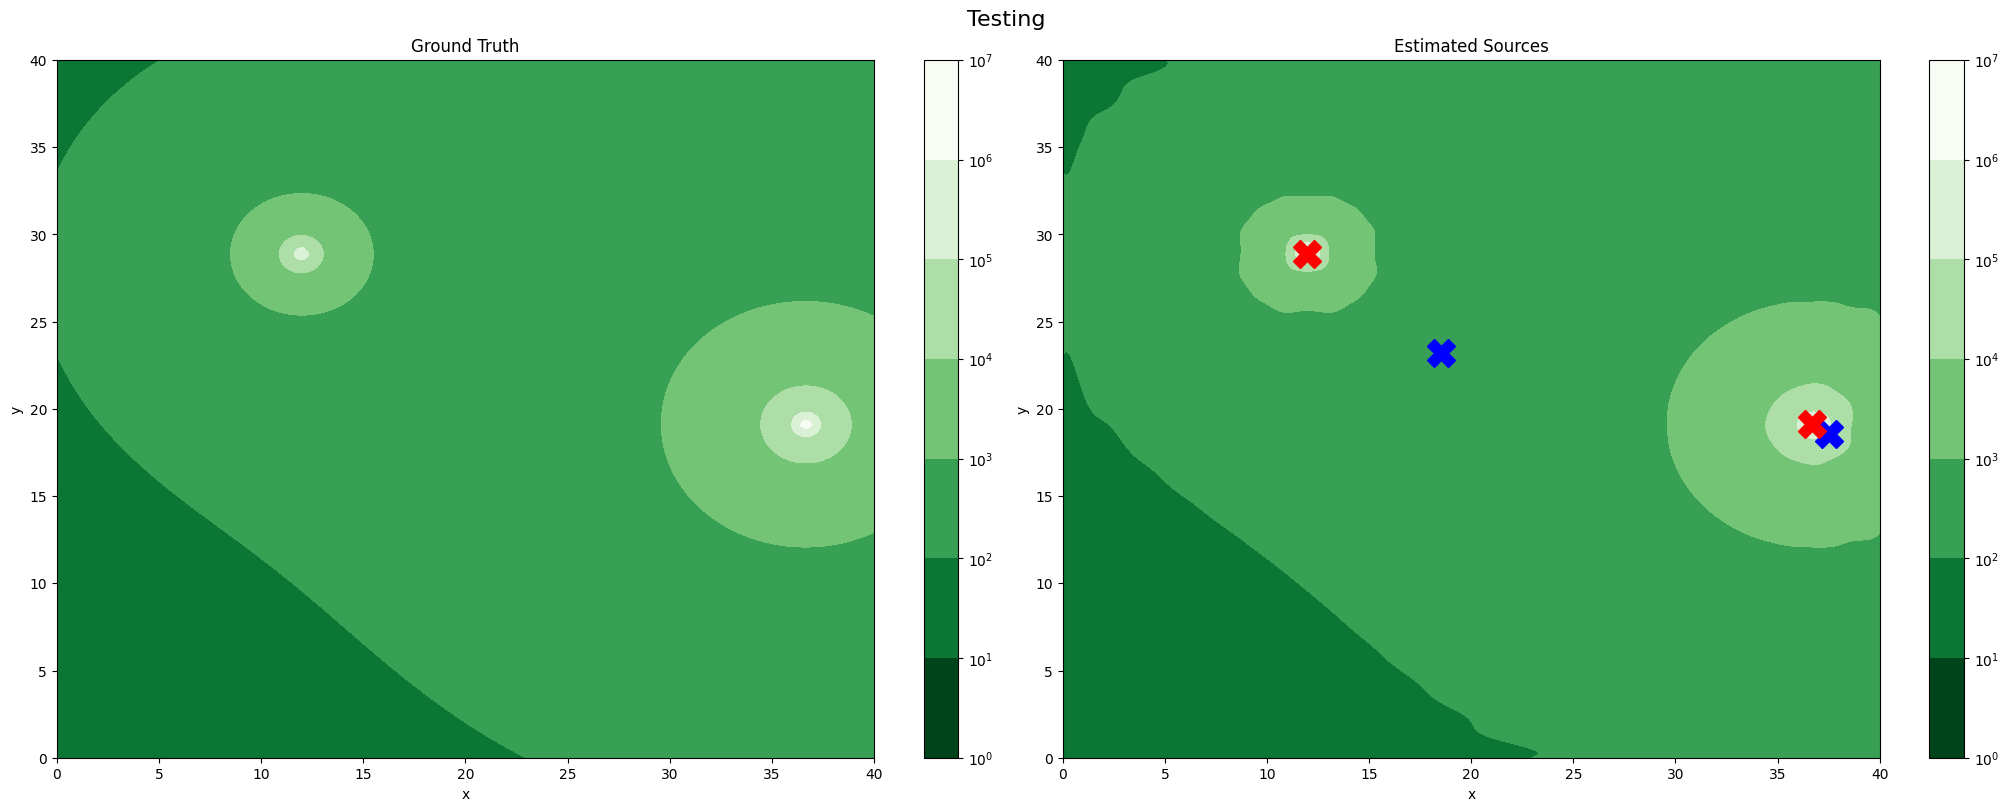

{'alpha': 1e-10, 'copy_X_train': True, 'kernel__k1': 1**2 ** 2, 'kernel__k2': RBF(length_scale=1), 'kernel__k1__kernel': 1**2, 'kernel__k1__exponent': 2, 'kernel__k1__kernel__constant_value': 1, 'kernel__k1__kernel__constant_value_bounds': (1e-05, 5), 'kernel__k2__length_scale': 1, 'kernel__k2__length_scale_bounds': (1e-05, 50), 'kernel': 1**2 ** 2 * RBF(length_scale=1), 'n_restarts_optimizer': 10, 'n_targets': None, 'normalize_y': True, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None}


In [207]:
# predict local maximuns from ground truth and put black crosses ~
plot_sources(obs_wp, obs_vals, sample_scenario, predicted_scenario,zpred=ZP)
print(gp.get_params())

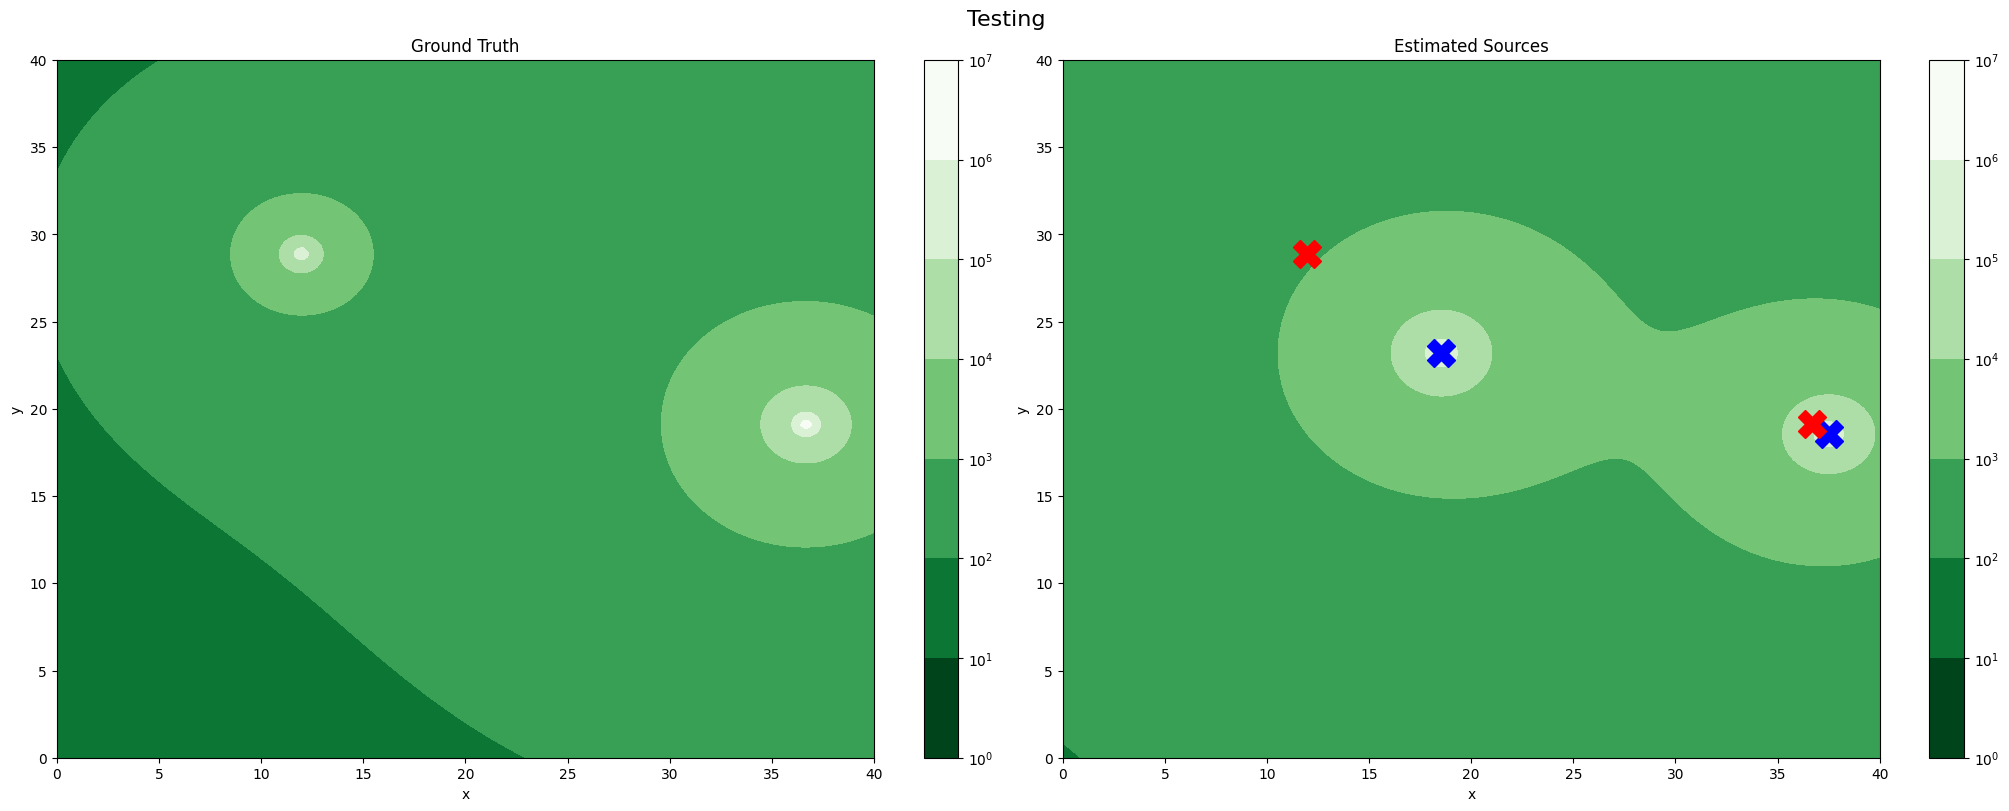

In [208]:
plot_sources(obs_wp, obs_vals, sample_scenario, predicted_scenario, collect_estimates)

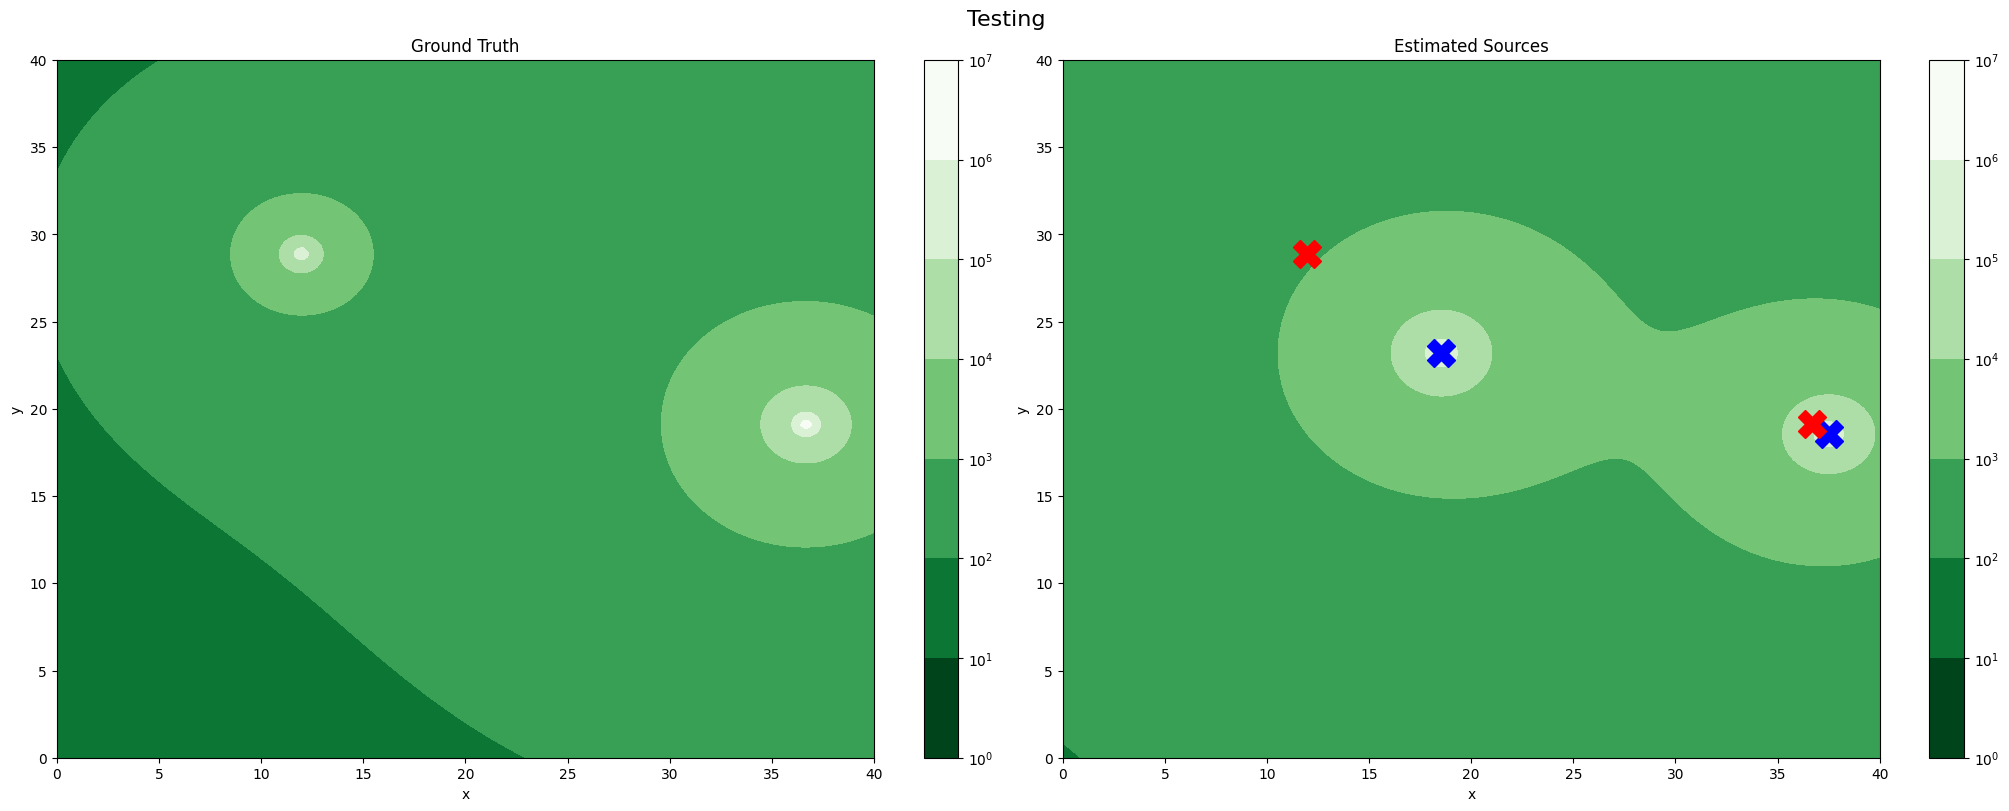

In [209]:
plot_sources(obs_wp, obs_vals, sample_scenario, predicted_scenario, collect_estimates)


In [291]:
# RMSE = np.sqrt(np.mean((np.log10(Z_true + 1) - np.log10(Z_pred + 1))**2))
# WEIGHTED_RMSE = np.sqrt(np.sum((Z_true * (np.log10(Z_true + 1) - np.log10(Z_pred + 1))**2)) / np.sum(Z_true))

RMSE_FUNCTION = lambda x,y: np.sqrt(np.mean((np.log10(x + 1) - np.log10(y + 1))**2))
WEIGHTED_RMSE = lambda x,y: np.sqrt(np.mean((x * (np.log10(x + 1) - np.log10(y + 1))**2)) / np.sum(x))

print(RMSE_FUNCTION(sample_scenario.g_truth, sample_scenario.g_truth), WEIGHTED_RMSE(sample_scenario.g_truth, sample_scenario.g_truth))
print(RMSE_FUNCTION(sample_scenario.g_truth, predicted_scenario.g_truth), WEIGHTED_RMSE(sample_scenario.g_truth, predicted_scenario.g_truth))
print(RMSE_FUNCTION(sample_scenario.g_truth, ZP), WEIGHTED_RMSE(sample_scenario.g_truth, ZP))


0.0 0.0
0.4868725530137826 0.006206604939083866
0.023546478944804286 0.002441963391289473


In [211]:
print(np.array(RMSES).mean())
print(np.array(WRMSES).mean())

nan
nan


In [266]:
import numpy as np
import time
from matplotlib import pyplot as plt
import threading
from scipy.spatial import KDTree
from scipy.stats import uniform
from informative import BaseInformative
from tqdm import tqdm
from path_planning_utils import estimate_sources_bayesian
from rrt_utils import choose_parent, cost, line_cost, obstacle_free, rewire, \
                      near, steer, nearest, add_node, trace_path_to_root, \
                      node_selection_key_distance, InformativeTreeNode, TreeNode, TreeCollection
from radiation import RadiationField
class InformativeRRTBaseClass():
    """
    Base class for Informative RRT Path Planning algorithms. Allows multiple agents
    """
    def __init__(self, scenario, beta_t=5.0, budget=375, d_waypoint_distance=2.5, num_agents=1,
                 n_samples=25, s_stages=10, lambda_b=1, max_sources=3, budget_iter=10, **kwargs):
        # RRT Parameters
        self.scenario = scenario
        self.beta_t = beta_t
        self.budget = [budget] * num_agents
        self.d_waypoint_distance = d_waypoint_distance
        self.num_agents = num_agents
        self.budget_iter = budget_iter
        self.name = None
        self.trees = TreeCollection()
        self.uncertainty_reduction = []
        self.time_taken = 0
        self.new_scenario = None
        self.budget = [budget] * num_agents

        # Source Metric Parameters
        self.n_samples = n_samples
        self.s_stages = s_stages
        self.lambda_b = lambda_b
        self.max_sources = max_sources

        # Number of agents specific attributes
        if self.num_agents > 1:
            self.agent_positions = [np.array([0.5 + i * (self.scenario.workspace_size[0] - 1) / (num_agents - 1), 0.5]) for i in range(num_agents)]
        else:
            self.agent_positions = [np.array([0.5, 0.5])]
        self.agents_trees = [TreeCollection() for _ in range(num_agents)]
        self.agents_obs_wp = [[] for _ in range(num_agents)]
        self.agents_measurements = [[] for _ in range(num_agents)]
        self.agents_full_path = [[] for _ in range(num_agents)]
        self.tree_nodes = [[] for _ in range(num_agents)]
        self.agents_roots = [None] * num_agents

    def initialize_trees(self, start_position, agent_idx):
        self.agents_roots[agent_idx] = InformativeTreeNode(start_position)
        self.tree_nodes[agent_idx] = [self.agents_roots[agent_idx]]
        print(f"Agent {agent_idx} root: {self.agents_roots[agent_idx]}")
        self.trees.add(self.agents_roots[agent_idx])

    def run(self):
        """
        Generic run method for  the Informative RRT Path Planning algorithm
        """
        budget_portion = [budget / self.budget_iter for budget in self.budget]

        for i in range(self.num_agents):
            self.initialize_trees(self.agent_positions[i], i)
        start_time = time.time()
        # self.plot_agents_paths_threaded()
        with tqdm(total=sum(self.budget), desc="Running " + str(self.num_agents) + " Agent " + self.name) as pbar:
            while any(b > 0 for b in self.budget):
                for i in range(self.num_agents):
                    # print(f"Agent {i} budget: {self.budget[i]}")
                    if self.budget[i] > 0:
                        self.tree_generation(budget_portion[i], i)
                        path = self.path_selection(i)
                        budget_spent = self.calculate_budget_spent(path)
                        self.update_observations_and_model(path, i)
                        self.agents_full_path[i].extend(path)
                        self.budget[i] -= budget_spent
                        if self.budget[i] < budget_portion[i]:
                            budget_portion[i] = self.budget[i]
                
                        pbar.update(budget_spent)
                        if len(path) > 0 and self.budget[i] > 0:
                            self.initialize_trees(path[-1], i)
                self.information_update()
        self.time_taken = time.time() - start_time
        return self.finalize_all_agents()

    def update_observations_and_model(self, path, agent_idx):
        if path:
            for point in path:
                measurement = self.scenario.simulate_measurements([point])[0]
                self.agents_measurements[agent_idx].append(measurement)
                self.agents_obs_wp[agent_idx].append(point)
        

    def calculate_budget_spent(self, path):
        if not path:
            return 0
        path_array = np.array(path)
        if path_array.ndim > 1:
            return np.sum(np.linalg.norm(np.diff(path_array, axis=0), axis=1))
        return 0
    
    def finalize_all_agents(self):
        self.measurements = sum((agent_measurements for agent_measurements in self.agents_measurements), [])
        self.obs_wp = sum((agent_wp for agent_wp in self.agents_obs_wp), [])
        self.full_path = sum((agent_path for agent_path in self.agents_full_path), [])
        self.obs_wp = np.array(self.obs_wp)
        self.full_path = np.array(self.full_path).reshape(-1, 2).T

        if hasattr(self, 'best_estimates') and self.best_estimates.size > 0:
            num_sources = len(self.best_estimates)
            self.new_scenario = RadiationField(num_sources=num_sources, workspace_size=self.scenario.workspace_size,
                                        intensity_range=(1e4, 1e5))
            for i, estimate in enumerate(self.best_estimates):
                self.new_scenario.update_source(i, *estimate)
            print("\nBest Estimates: ", self.best_estimates, "\n")
            std = np.zeros_like(self.scenario.g_truth)
            Z_pred = self.new_scenario.g_truth
        else:
            Z_pred, std = self.scenario.predict_spatial_field(self.obs_wp, np.array(self.measurements))
        
        return Z_pred, std
    def tree_generation(self, budget_portion, agent_idx):
        raise NotImplementedError("tree_generation method must be implemented in the subclass")
    
    def path_selection(self, agent_idx):
        raise NotImplementedError("path_selection method must be implemented in the subclass")

    def information_update(self):
        raise NotImplementedError("information_update method must be implemented in the subclass")    


In [267]:
# Generic point source gain calculation strategy
def point_source_gain_no_penalties(self, node, agent_idx):
    """
    Generic point source gain calculation strategy for Multi-Agent Informative Source Metric RRT Path Planning algorithms

    Parameters:
    - self: Assumes a class that inherits from InformativeRRTBaseClass
    - node: The node for which the point source gain is to be calculated
    - agent_idx: The index of the agent in the multi-agent system

    """
    # Gain_nodet = Gain_nodet-1 + Gain_nodet_src
    def sources_gain(node):
        x_t, y_t = node.point
        point_source_gain = 0
        for source in self.best_estimates:
            x_k, y_k, intensity = source
            d_src = np.linalg.norm([x_t - x_k, y_t - y_k])
            point_source_gain += intensity / d_src**2
        return point_source_gain

    final_gain = 0
    current_node = node
    while current_node.parent:
        final_gain += sources_gain(current_node)
        current_node = current_node.parent
    return final_gain
def point_source_gain_only_distance_penalty(self, node, agent_idx):
    """
    Generic point source gain calculation strategy for Multi-Agent Informative Source Metric RRT Path Planning algorithms

    Parameters:
    - self: Assumes a class that inherits from InformativeRRTBaseClass
    - node: The node for which the point source gain is to be calculated
    - agent_idx: The index of the agent in the multi-agent system

    """
    # Gain_nodet = Gain_nodet-1 + Gain_nodet_src
    def sources_gain(node):
        x_t, y_t = node.point
        point_source_gain = 0
        for source in self.best_estimates:
            x_k, y_k, intensity = source
            d_src = np.linalg.norm([x_t - x_k, y_t - y_k])
            point_source_gain += intensity / d_src**2
        return point_source_gain*distance_penalty(node)

    # C_dist^(t,t-1) = exp(-n_src^gain * d_t,t-1) with n_src^gain = 0.1 and d_t,t-1 = ||x_t - x_t-1||
    def distance_penalty(node):
        if node.parent:
            return np.exp(-0.1 * np.linalg.norm(node.point - node.parent.point))
        return 0

    final_gain = 0
    current_node = node
    while current_node.parent:
        final_gain += sources_gain(current_node) 
        current_node = current_node.parent
    return final_gain
def point_source_gain_distance_rotation_penalty(self, node, agent_idx):
    """
    Generic point source gain calculation strategy for Multi-Agent Informative Source Metric RRT Path Planning algorithms

    Parameters:
    - self: Assumes a class that inherits from InformativeRRTBaseClass
    - node: The node for which the point source gain is to be calculated
    - agent_idx: The index of the agent in the multi-agent system

    """
    # Gain_nodet = Gain_nodet-1 + Gain_nodet_src
    def sources_gain(node):
        x_t, y_t = node.point
        point_source_gain = 0
        for source in self.best_estimates:
            x_k, y_k, intensity = source
            d_src = np.linalg.norm([x_t - x_k, y_t - y_k])
            point_source_gain += intensity / d_src**2
        return point_source_gain*distance_penalty(node)*rotation_penalty(node)

    # C_dist^(t,t-1) = exp(-n_src^gain * d_t,t-1) with n_src^gain = 0.1 and d_t,t-1 = ||x_t - x_t-1||
    def distance_penalty(node):
        if node.parent:
            return np.exp(-0.1 * np.linalg.norm(node.point - node.parent.point))
        return 0
    # C_rot^(t, t-1) = exp(theta_t^2/sigma_theta^2) with sigma_theta = 0.1 and theta_t = atan2(y_t - y_t-1, x_t - x_t-1)
    def rotation_penalty(node):
        if node.parent:
            theta_t = np.arctan2(node.point[1] - node.parent.point[1], node.point[0] - node.parent.point[0])
            return np.exp(theta_t**2 / 0.1)
        return 0

    final_gain = 0
    current_node = node
    while current_node.parent:
        final_gain += sources_gain(current_node) 
        current_node = current_node.parent
    return final_gain
def point_source_gain_all(self, node, agent_idx):
    """
    Generic point source gain calculation strategy for Multi-Agent Informative Source Metric RRT Path Planning algorithms

    Parameters:
    - self: Assumes a class that inherits from InformativeRRTBaseClass
    - node: The node for which the point source gain is to be calculated
    - agent_idx: Tsahe index of the agent in the multi-agent system

    """
    # Gain_nodet = Gain_nodet-1 + Gain_nodet_src
    def sources_gain(node):
        x_t, y_t = node.point
        point_source_gain = 0
        for source in self.best_estimates:
            x_k, y_k, intensity = source
            d_src = np.linalg.norm([x_t - x_k, y_t - y_k])
            point_source_gain += intensity / d_src**2
        return point_source_gain*distance_penalty(node)*rotation_penalty(node)*exploitation_penalty(node)

    # C_dist^(t,t-1) = exp(-n_src^gain * d_t,t-1) with n_src^gain = 0.1 and d_t,t-1 = ||x_t - x_t-1||
    def distance_penalty(node):
        if node.parent:
            return np.exp(-0.1 * np.linalg.norm(node.point - node.parent.point))
        return 0
    # C_rot^(t, t-1) = exp(theta_t^2/sigma_theta^2) with sigma_theta = 0.1 and theta_t = atan2(y_t - y_t-1, x_t - x_t-1)
    def rotation_penalty(node):
        if node.parent:
            theta_t = np.arctan2(node.point[1] - node.parent.point[1], node.point[0] - node.parent.point[0])
            return np.exp(theta_t**2 / 0.1)
        return 0
    def exploitation_penalty(node):
        # If the node has 5 or more obs_wp from other agents in a d_waypoint_distance radius, return 0
        # return a np.exp(-n_obs_wp^exploit) with n_obs_wp = number of obs_wp in a d_waypoint_distance radius
        if len(self.obs_wp) > 0:
            n_obs_wp = 0
            for i in range(len(self.agent_positions)):
                if i != agent_idx:
                    n_obs_wp += len([obs_wp for obs_wp in self.agents_obs_wp[i] if np.linalg.norm(node.point - obs_wp) < self.d_waypoint_distance])
            if n_obs_wp >= 5:
                return 0
            return np.exp(-n_obs_wp)
        
    final_gain = 0
    current_node = node
    while current_node.parent:
        final_gain += sources_gain(current_node) 
        current_node = current_node.parent
    return final_gain	

def rig_tree_generation(self, budget_portion, agent_idx, gain_function=point_source_gain_no_penalties):
    """
    Generic tree generation strategy for Multi-Agent Informative Source Metric RRT Path Planning algorithms

    Parameters:
    - self: Assumes a class that inherits from InformativeRRTBaseClass
    - budget_portion: The portion of the budget allocated for this iteration
    - agent_idx: The index of the agent in the multi-agent system~

    """
    distance_travelled = 0
    while distance_travelled < budget_portion:
        random_point = np.random.rand(2) * self.scenario.workspace_size
        nearest_node = nearest(self.tree_nodes[agent_idx], random_point)
        new_point = steer(nearest_node, random_point, d_max_step=self.d_waypoint_distance)

        if obstacle_free(nearest_node.point, new_point):
            new_node = InformativeTreeNode(new_point)    
            X_near = near(new_node, self.tree_nodes[agent_idx], self.d_waypoint_distance)
            new_node = choose_parent(X_near, nearest_node, new_node)
            add_node(self.tree_nodes[agent_idx], new_node, nearest_node)
            distance_travelled += np.linalg.norm(new_node.point - nearest_node.point)
            
            # Update the information gain for the new node
            new_node.information = gain_function(self, new_node, agent_idx)

            rewire(X_near, new_node)
            if distance_travelled >= budget_portion:
                break

        self.agents_trees[agent_idx].add(self.agents_roots[agent_idx])
# Source Metric Information Updated Generic Strategy
def source_metric_information_update(self):
    """
    Generic information update strategy for Multi-Agent Informative Source Metric RRT Path Planning algorithms

    Parameters:
    - self: Assumes a class that inherits from InformativeRRTBaseClass

    """
    self.measurements = sum((agent_measurements for agent_measurements in self.agents_measurements), [])
    self.full_path = sum((agent_path for agent_path in self.agents_full_path), [])
    # every 5 observation
    if len(self.measurements) % 5 == 0 and len(self.measurements) > 0:
        estimates, _, bic = estimate_sources_bayesian(
            self.full_path, self.measurements, self.lambda_b,
            self.max_sources, self.n_samples, self.s_stages
        )
        if bic > self.best_bic:
            self.best_bic = bic
            self.best_estimates = estimates.reshape((-1, 3))
# Generic Informative Source metric Path Selection Strategy
def informative_source_metric_path_selection(self, agent_idx):
    """
    Generic path selection strategy for Multi-Agent Informative Source Metric RRT Path Planning algorithms

    Parameters:
    - self: Assumes a class that inherits from InformativeRRTBaseClass
    - agent_idx: The index of the agent in the multi-agent system

    """
    leaf_nodes = [node for node in self.tree_nodes[agent_idx] if not node.children]
    if not leaf_nodes:
        return []  # Return empty list if no leaf nodes are available

    # Choose path based on radiation gain
    if self.best_estimates.size == 0:
        # print("Selecting leaf node randomly")
        selected_leaf = np.random.choice(leaf_nodes)  # Random selection if no estimates are available
    else:
        # use node.information as the key for selection
        # print("Selecting leaf node with the highest information gain")
        selected_leaf = max(leaf_nodes, key=lambda node: node.information)
    # Trace the path from the selected leaf back to the root
    return trace_path_to_root(selected_leaf)
def plot_tree_node(node, ax, color='blue'):
    """
    Recursively plots each node in the tree.
    
    Parameters:
    - node: The TreeNode to plot.
    - ax: The matplotlib axis to plot on.
    - color: The color of the lines. Default is 'blue'.
    """
    if node.parent:
        ax.plot([node.point[0], node.parent.point[0]], [node.point[1], node.parent.point[1]], color=color)
    for child in node.children:
        plot_tree_node(child, ax, color=color)


In [289]:
class RRTRIG_PointSourceInformative_SourceMetric_PathPlanning(InformativeRRTBaseClass):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.best_estimates = np.array([])
        self.best_bic = -np.inf
        self.name = "RRTRIG_PointSourceInformative_SourceMetric_Path"

    def tree_generation(self, budget_portion, agent_idx):
        # rrt_tree_generation(self, budget_portion, agent_idx)
        rig_tree_generation(self, budget_portion, agent_idx, gain_function=point_source_gain_no_penalties)

    def path_selection(self, agent_idx):
        return informative_source_metric_path_selection(self, agent_idx)

    def information_update(self):
        source_metric_information_update(self)
strategy = RRTRIG_PointSourceInformative_SourceMetric_PathPlanning(sample_scenario, num_agents=2,
                                                                    beta_t=5.0, budget=200, d_waypoint_distance=2.5,
                                                                    n_samples=500, s_stages=25, lambda_b=1, max_sources=3,
                                                                    budget_iter=10)

Z_pred, std = strategy.run()

Agent 0 root: <rrt_utils.InformativeTreeNode object at 0x0000023168F770A0>
Agent 1 root: <rrt_utils.InformativeTreeNode object at 0x0000023168F74070>


Running 2 Agent RRTRIG_PointSourceInformative_SourceMetric_Path:   0%|          | 0/400 [00:00<?, ?it/s]

Agent 0 root: <rrt_utils.InformativeTreeNode object at 0x0000023168F75D80>
Agent 1 root: <rrt_utils.InformativeTreeNode object at 0x0000023160CD9DE0>
Agent 0 root: <rrt_utils.InformativeTreeNode object at 0x000002315ED894E0>
Agent 1 root: <rrt_utils.InformativeTreeNode object at 0x0000023158482BC0>
Agent 0 root: <rrt_utils.InformativeTreeNode object at 0x0000023158088BB0>
Agent 1 root: <rrt_utils.InformativeTreeNode object at 0x000002315F2AB010>
Agent 0 root: <rrt_utils.InformativeTreeNode object at 0x000002315F2A99F0>
Agent 1 root: <rrt_utils.InformativeTreeNode object at 0x000002315DDFE140>


Running 2 Agent RRTRIG_PointSourceInformative_SourceMetric_Path:  49%|████▊     | 194.097565648031/400 [00:03<00:03, 57.09it/s] 

Agent 0 root: <rrt_utils.InformativeTreeNode object at 0x000002315F2ABEE0>
Agent 1 root: <rrt_utils.InformativeTreeNode object at 0x000002315F2A85E0>
Agent 0 root: <rrt_utils.InformativeTreeNode object at 0x00000231610A20E0>
Agent 1 root: <rrt_utils.InformativeTreeNode object at 0x00000231610A30A0>
Agent 0 root: <rrt_utils.InformativeTreeNode object at 0x00000231610A3CD0>
Agent 1 root: <rrt_utils.InformativeTreeNode object at 0x00000231610A3B20>
Agent 0 root: <rrt_utils.InformativeTreeNode object at 0x00000231610A3130>
Agent 1 root: <rrt_utils.InformativeTreeNode object at 0x00000231610A3A00>
Agent 0 root: <rrt_utils.InformativeTreeNode object at 0x00000231610A3430>
Agent 1 root: <rrt_utils.InformativeTreeNode object at 0x00000231610A2E30>

Best Estimates:  [[6.35212813e+00 3.19444811e+01 5.31517863e+04]
 [3.60431270e+01 1.92515321e+01 4.03116393e+04]] 



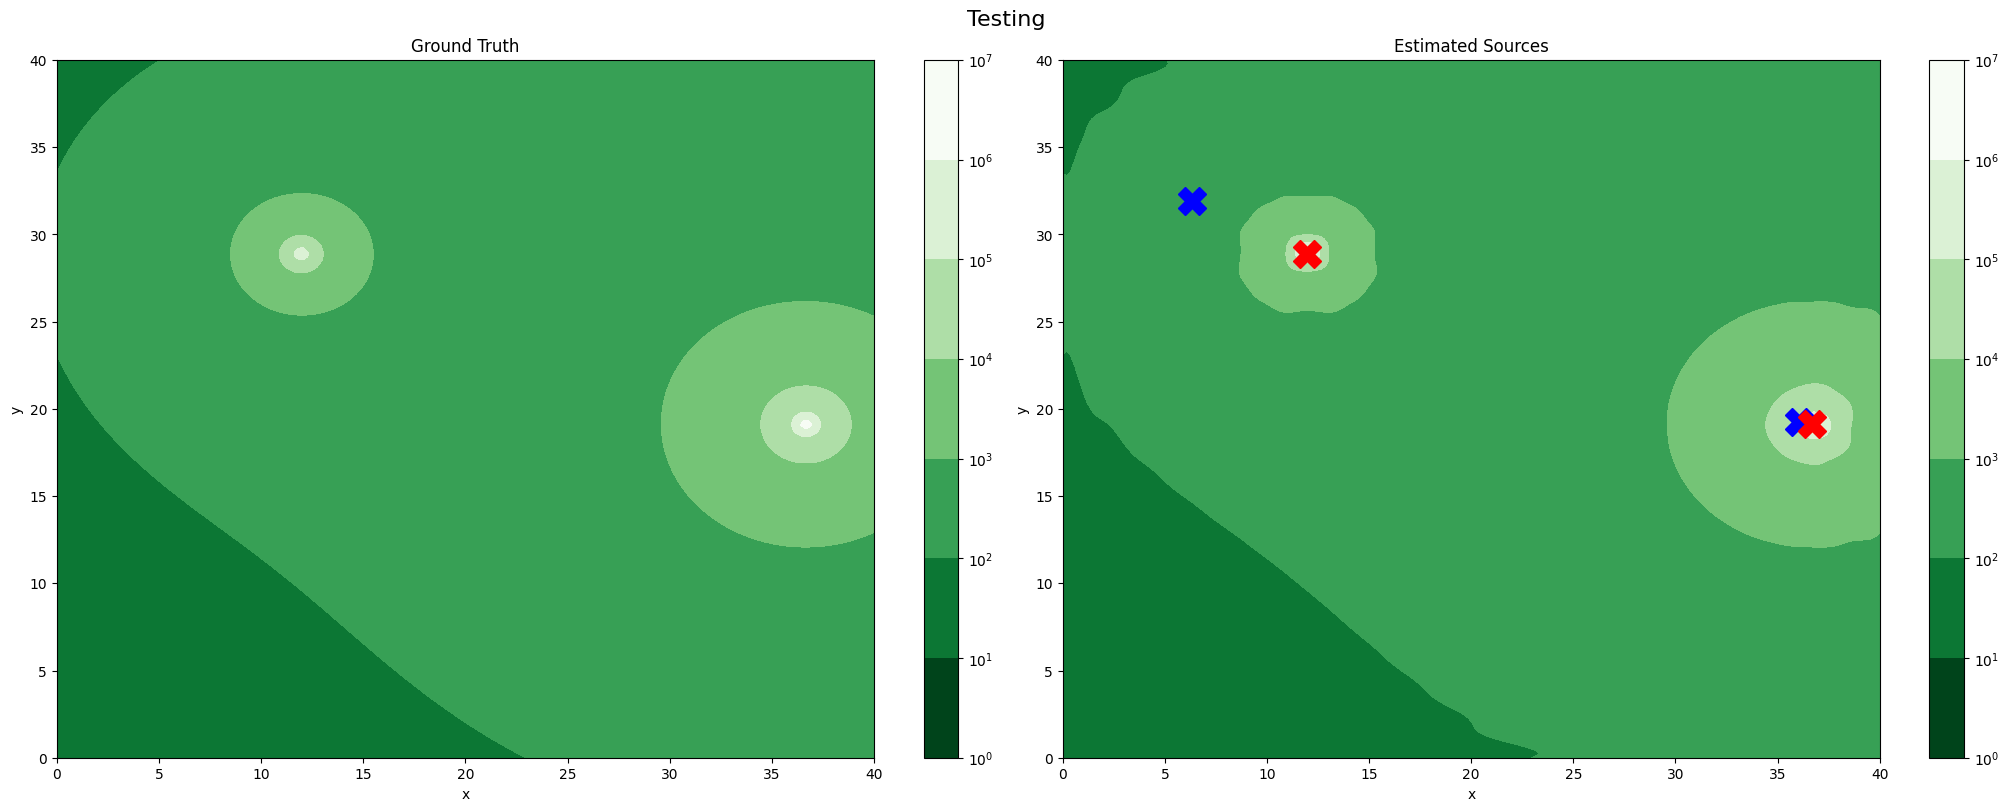

Trees List <rrt_utils.TreeCollection object at 0x0000023168F75E40>


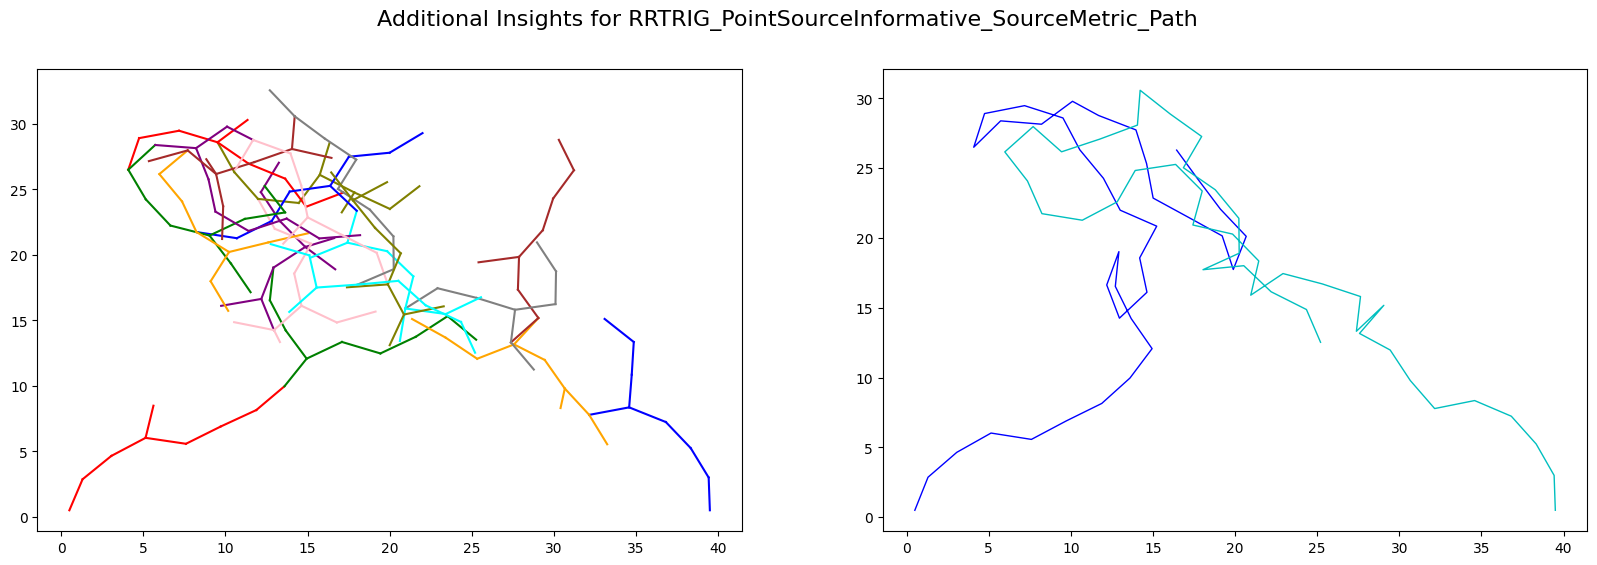

In [292]:

plot_sources(strategy.obs_wp, strategy.measurements, sample_scenario, strategy.new_scenario, zpred=ZP)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle(f'Additional Insights for {strategy.name}', fontsize=16)
if hasattr(strategy, 'num_agents'):
    # plot each with a different color except for green
    # blue, cyan, magenta, yellow, black, white
    colors_path = ['b', 'c', 'm', 'y', 'k', 'w']
    for i in range(strategy.num_agents):
        current_x, current_y = np.array(strategy.agents_full_path[i]).reshape(-1, 2).T
        axs[1].plot(current_x, current_y, label=f'Agent {i+1} Path', linewidth=1, color=colors_path[i])
print("Trees List", strategy.trees)
# Plot all trees and the final chosen path
# generate a list of 10 colors
colors_tree = ["red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"]
for tree_root in strategy.trees.trees:
    plot_tree_node(tree_root, axs[0], color=colors_tree[strategy.trees.trees.index(tree_root) % len(colors_tree)])

[1, 1]
[1 1]
0.0
[6 6]
7.0710678118654755
[16 16]
21.213203435596427
[31 31]
42.42640687119285
[51 51]
70.71067811865476
[76 76]
106.06601717798213
[106 106]
148.49242404917499
[141 141]
197.9898987322333
[181 181]
254.55844122715712
[226 226]
318.1980515339464


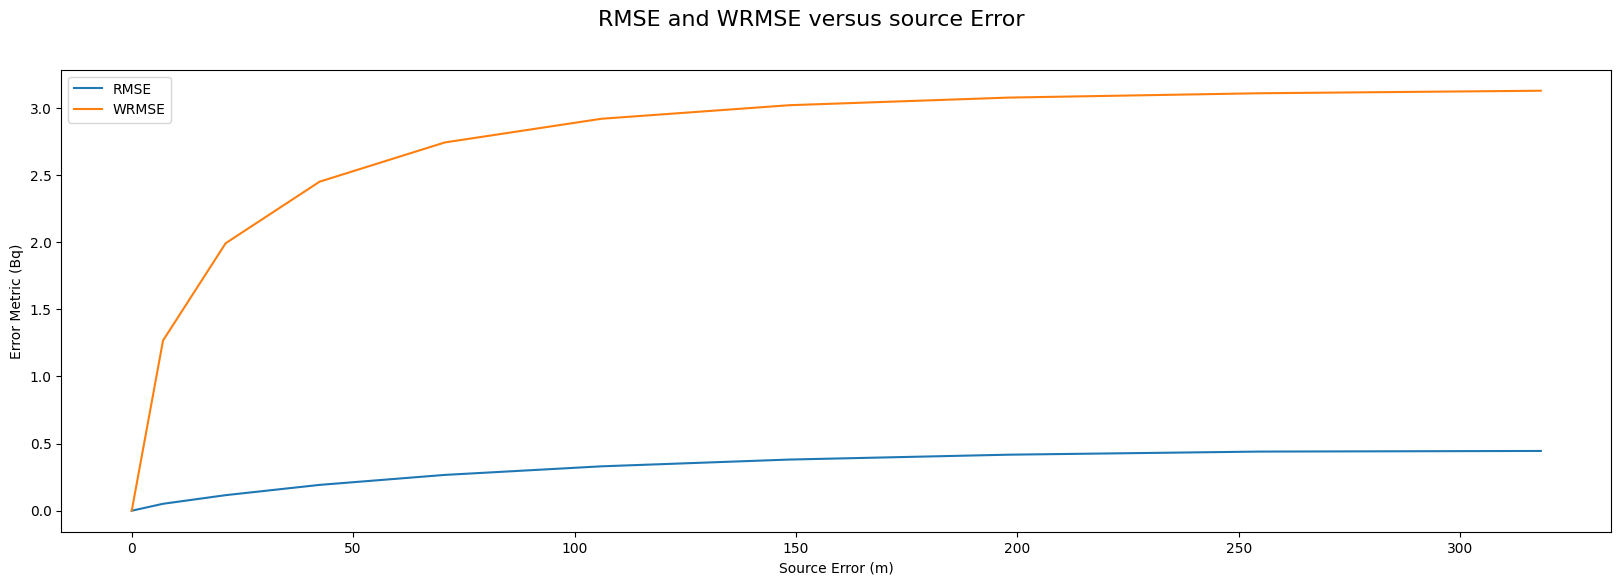

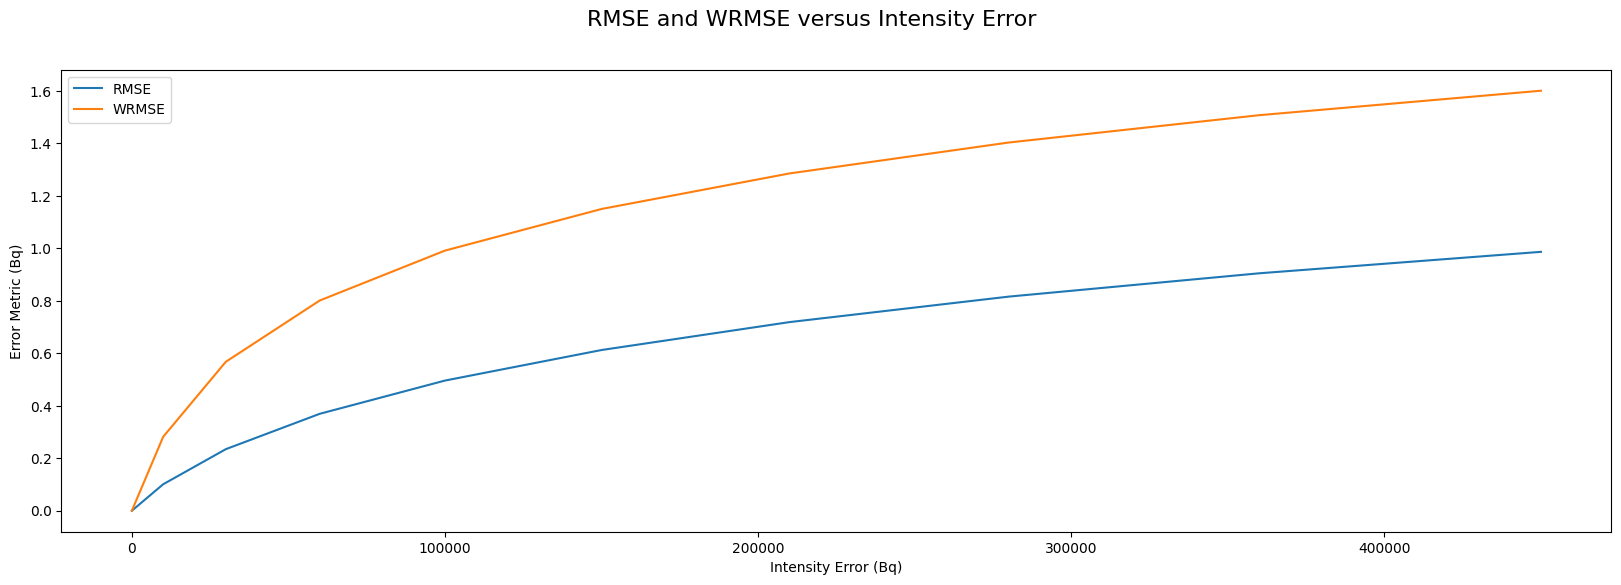

In [373]:
# Plot the evolution of WRMSE and RMSE as the distance error from one source increases~
RMSE_FUNCTION = lambda x,y: np.sqrt(np.mean((np.log10(x + 1) - np.log10(y + 1))**2))
WEIGHTED_RMSE = lambda x,y: np.sqrt(np.sum((x * (np.log10(x + 1) - np.log10(y + 1))**2)) / np.sum(x))
ERROR = lambda real,estimate: np.linalg.norm(real - estimate)

# get the real source location
real_source = sample_scenario.sources[0]
real_scenario = RadiationField(
    num_sources=1,
    workspace_size=(300, 300),
    intensity_range=(1e4, 1e10),
    seed=50
)
real_scenario.update_source(0, 1, 1, 1e4)
real_source = real_scenario.g_truth
print(real_scenario.sources[0][:2])
predicted_scenario = RadiationField(
    num_sources=1,
    workspace_size=(300, 300),
    intensity_range=(1e4, 1e10),
    seed=50
)

source_test_estimate = real_scenario.sources[0][:2]
predicted_scenario.update_source(0, source_test_estimate[0], source_test_estimate[1], real_scenario.sources[0][2])
errors = []
rmses = []
wrmses = []
for i in range(10):
    source_test_estimate = source_test_estimate + np.array([i*5, i*5])
    print(source_test_estimate)
    predicted_scenario.update_source(0, source_test_estimate[0], source_test_estimate[1], real_scenario.sources[0][2])
    test_estimate = predicted_scenario.g_truth
    error = ERROR(real_scenario.sources[0][:2], source_test_estimate)
    print(error)
    rmse = RMSE_FUNCTION(real_source, test_estimate)
    wrmse = WEIGHTED_RMSE(real_source, test_estimate)
    errors.append(error)
    rmses.append(rmse)
    wrmses.append(wrmse)

fig, axs = plt.subplots(1, 1, figsize=(20, 6))
fig.suptitle(f'RMSE and WRMSE versus source Error', fontsize=16)
plt.plot(errors, rmses, label="RMSE")
plt.plot(errors, wrmses, label="WRMSE")
plt.xlabel("Source Error (m)")
plt.ylabel("Error Metric (Bq)")
plt.legend()

intensity_test_estimate = real_scenario.sources[0][2]
predicted_scenario.update_source(0, source_test_estimate[0], source_test_estimate[1], real_scenario.sources[0][2])
errors = []
rmses = []
wrmses = []
for i in range(10):
    intensity_test_estimate = intensity_test_estimate + i*1e4
    # print(intensity_test_estimate)
    predicted_scenario.update_source(0, real_scenario.sources[0][0], real_scenario.sources[0][1], intensity_test_estimate)
    test_estimate = predicted_scenario.g_truth
    error = ERROR(real_scenario.sources[0][2], intensity_test_estimate)
    rmse = RMSE_FUNCTION(real_source, test_estimate)
    wrmse = WEIGHTED_RMSE(real_source, test_estimate)
    errors.append(error)
    rmses.append(rmse)
    wrmses.append(wrmse)

fig, axs = plt.subplots(1, 1, figsize=(20, 6))
fig.suptitle(f'RMSE and WRMSE versus Intensity Error', fontsize=16)
plt.plot(errors, rmses, label="RMSE")
plt.plot(errors, wrmses, label="WRMSE")
plt.xlabel("Intensity Error (Bq)")
plt.ylabel("Error Metric (Bq)")
plt.legend()
